# Objective: Artificial Neural Network Classification for Handwritten Digits Using MNIST
Here, I'm going to build an aritifical neural network classification model using PyTorch to classify handwritten digits using MNIST training data set.

## Import Libraries

In [1]:

import torch
import torch.utils
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

## Load Data
This covers how to download the data and load the data into the code.

In [2]:
# load train dataset
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

In [3]:
# analyze train dataset
train_dataset.data
train_dataset.data.max()
N, D1, D2 = train_dataset.data.shape
train_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [4]:
# load test data
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [5]:
# analyze test dataset
test_dataset.data
test_dataset.data.max()
test_dataset.data.shape
test_dataset.targets

tensor([7, 2, 1,  ..., 4, 5, 6])

## Preprocess Data
This covers how to create batch using DataLoader

In [6]:
# DataLoader: automatically generates batches and takes care of shuffling
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)
# shuffling is applied to only train_loader to avoid any unwanted correlation during training

In [7]:
# understand DataLoader better
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                         batch_size=1, 
                                         shuffle=True)
for x, y in tmp_loader:
    print(x)
    print(x.shape)
    print(y)
    print(y.shape)
    break

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [8]:
# confirm whether the data is normalized or not
train_dataset.transform(train_dataset.data.numpy()).max()


tensor(1.)

## Build Model
This covers how to build a artificial neural network classification model using MNIST dataset to train. Since the dataset is big enough, we can use GPU for faster process if available.

In [9]:
# build the model
hidden_layer = 128
K = max(train_dataset.targets.numpy()) + 1      # the number of classes

model = nn.Sequential(
    nn.Linear(D1 * D2, hidden_layer),
    nn.ReLU(),      # activation function as ReLU
    nn.Linear(hidden_layer, K)
)
# we do not need to apply softmax here since
# softmax is combined with crossentropy loss for numerical stability

In [10]:
# activate gpu if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# send the model details to the device
model.to(device)

cuda:0


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## Training
This covers how to train the artificial neural network classification model with the input data that we processed.

In [12]:
# the number of epochs
epochs = 10

# losses will be stored to plot the results
# storage for losses per each epoch
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)

# training
for epoch in range(epochs):
    train_loss = []     # storage for train loss per each batch
    for inputs, targets in train_loader:
        # move data to device
        inputs, targets = inputs.to(device), targets.to(device)
        
        # reshape the input data
        inputs = inputs.view(-1, D1 * D2)
        
        # zero the parameter gradients to make sure they are zero
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # backward and optimize
        loss.backward()
        optimizer.step()
        
        # save the loss
        train_loss.append(loss.item())
        
    # get train loss per epoch as average loss of all the batches in that epoch
    train_loss = np.mean(train_loss)
    train_losses[epoch] = train_loss
    
    # get test loss per epoch as average loss of all the batches in that epoch
    test_loss = []      # storage for test loss per each batch
    for inputs, targets in test_loader:
        # move data to device
        inputs, targets = inputs.to(device), targets.to(device)
        
        # reshape the input data
        inputs = inputs.view(-1, D1 * D2)
        
        # zero the parameter gradients to make sure they are zero
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # backward and optimize
        loss.backward()
        optimizer.step()
        
        # save the loss
        test_loss.append(loss.item())
    
    # get test loss per epoch as average loss of all the batches in that epoch
    test_loss = np.mean(test_loss)
    test_losses[epoch] = test_loss
    
    # print out the progress
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 1/10, Train Loss: 0.4138, Test Loss: 0.2172
Epoch 2/10, Train Loss: 0.1803, Test Loss: 0.1391
Epoch 3/10, Train Loss: 0.1295, Test Loss: 0.1007
Epoch 4/10, Train Loss: 0.1002, Test Loss: 0.0769
Epoch 5/10, Train Loss: 0.0818, Test Loss: 0.0626
Epoch 6/10, Train Loss: 0.0674, Test Loss: 0.0509
Epoch 7/10, Train Loss: 0.0571, Test Loss: 0.0441
Epoch 8/10, Train Loss: 0.0494, Test Loss: 0.0368
Epoch 9/10, Train Loss: 0.0425, Test Loss: 0.0306
Epoch 10/10, Train Loss: 0.0367, Test Loss: 0.0266


## Result
This shows the result of the artificial neural network classification model by showing the loss evolution and calculating the accuracy of the model.

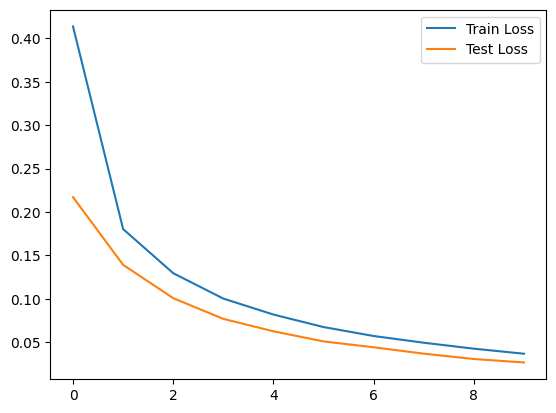

In [13]:
# plot the train loss and test loss per epoch
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

In [14]:
# train dataset
# calculate accuracy
n_correct = 0.
n_total = 0.

for inputs, targets in train_loader:
    # move data to device
    inputs, targets = inputs.to(device), targets.to(device)
    
    # reshape the input data
    inputs = inputs.view(-1, D1 * D2)
    
    # forward pass
    outputs = model(inputs)
    
    # get prediction by returning maximum value label
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total


# test dataset
# calculate accuracy
n_correct = 0.
n_total = 0.

for inputs, targets in test_loader:
    # move data to device
    inputs, targets = inputs.to(device), targets.to(device)
    
    # reshape the input data
    inputs = inputs.view(-1, D1 * D2)
    
    # forward pass
    outputs = model(inputs)
    
    # get prediction by returning maximum value label
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total

# print out the results
print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")


Train Accuracy: 0.9910, Test Accuracy: 0.9966


## Apendix: Confusion Matrix
This covers how to plot confusion matrix using the results that we got above.

In [15]:
# import libraries to plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[ 980    0    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0    0 1031    0    0    0    0    1    0    0]
 [   0    0    0 1010    0    0    0    0    0    0]
 [   0    0    0    0  972    0    0    1    0    9]
 [   0    0    0    5    0  886    0    0    0    1]
 [   0    3    0    1    0    0  954    0    0    0]
 [   0    2    0    0    0    0    0 1025    0    1]
 [   0    0    0    1    0    0    0    0  973    0]
 [   1    2    0    2    1    1    0    2    0 1000]]


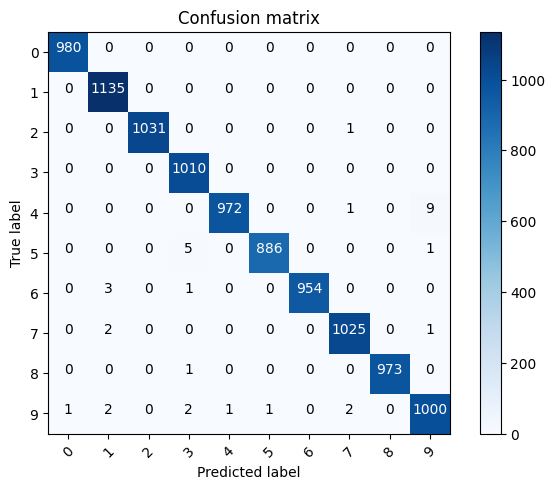

In [24]:
# get predictions in an array and plot the confusion matrix
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])

for inputs, targets in test_loader:
    # move data to device
    inputs = inputs.to(device)
    
    # reshape the input data
    inputs = inputs.view(-1, D1 * D2)
    
    # forward pass
    outputs = model(inputs)
    
    # get predictions
    _, predictions = torch.max(outputs, 1)
    
    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
    # need to bring the result back to cpu to process the plot
    
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))
